# ChatGPTに作ってもらった、実装の例のコードまとめ

## 中断時系列分析（線形回帰）

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

def interrupted_time_series_analysis(data, intervention_point):
    """
    Conduct an interrupted time series analysis.

    :param data: A pandas DataFrame with a 'time' and 'value' column.
    :param intervention_point: The time point at which the intervention occurred.
    :return: Regression results summary.
    """
    # Create a variable for time since start
    data['time_since_start'] = np.arange(len(data))

    # Create a binary variable for pre vs post intervention
    data['post_intervention'] = (data['time'] >= intervention_point).astype(int)

    # Create a variable for time since intervention
    data['time_since_intervention'] = data['time_since_start'] - intervention_point
    data['time_since_intervention'] = data['time_since_intervention'] * data['post_intervention']

    # Set up and fit the regression model
    X = sm.add_constant(data[['time_since_start', 'post_intervention', 'time_since_intervention']])
    y = data['value']
    model = sm.OLS(y, X).fit()

    return model.summary()

# Example usage:
data = pd.DataFrame({
    'time': np.arange(100),
    'value': np.concatenate([np.random.normal(5, 1, 50), np.random.normal(8, 1, 50)])
})
intervention_point = 50
print(interrupted_time_series_analysis(data, intervention_point))


                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     97.77
Date:                Fri, 13 Oct 2023   Prob (F-statistic):           4.48e-29
Time:                        00:37:59   Log-Likelihood:                -130.56
No. Observations:                 100   AIC:                             269.1
Df Residuals:                      96   BIC:                             279.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## 中断時系列分析（SARIMA）

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 期間の設定
periods = 200
intervention_point = 100

# ノイズの生成
np.random.seed(42)
noise = np.random.normal(loc=0, scale=5, size=periods)

# 介入前と介入後の時系列データの生成
before_intervention = np.linspace(0, 50, intervention_point) + noise[:intervention_point]
after_intervention = np.linspace(50, 80, periods - intervention_point) + noise[intervention_point:]

data = np.concatenate([before_intervention, after_intervention])
dates = pd.date_range(start="2020-01-01", periods=periods, freq='D')
df = pd.DataFrame(data, columns=["value"], index=dates)


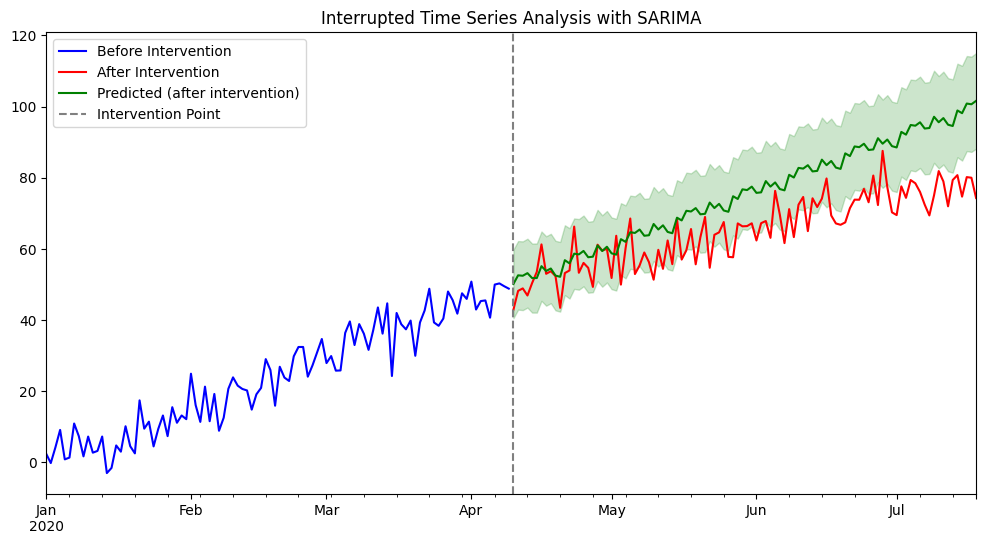

In [3]:
class ITS_SARIMA:
    def __init__(self, df, intervention):
        self.df = df
        self.intervention = intervention
        self.df_before = df[df.index < intervention]
        self.df_after = df[df.index >= intervention]

    def fit_sarima(self, order, seasonal_order, segment='before'):
        if segment == 'before':
            data = self.df_before['value']
        elif segment == 'after':
            data = self.df_after['value']
        else:
            raise ValueError("Segment should be either 'before' or 'after'.")

        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        return results

    def plot_results(self, order, seasonal_order):
        # Fit SARIMA model to data before and after the intervention
        results_before = self.fit_sarima(order, seasonal_order, 'before')
        
        # Predict data after the intervention using the model fit on data before the intervention
        predictions = results_before.get_prediction(start=self.df_after.index[0], end=self.df_after.index[-1], dynamic=True)
        prediction_mean = predictions.predicted_mean
        prediction_ci = predictions.conf_int()

        # Plot results
        plt.figure(figsize=(12, 6))
        self.df_before['value'].plot(label='Before Intervention', color='blue')
        self.df_after['value'].plot(label='After Intervention', color='red')
        prediction_mean.plot(label='Predicted (after intervention)', color='green')
        plt.fill_between(prediction_ci.index, prediction_ci.iloc[:, 0], prediction_ci.iloc[:, 1], color='green', alpha=0.2)
        plt.axvline(self.intervention, color='gray', linestyle='--', label='Intervention Point')
        plt.legend()
        plt.title('Interrupted Time Series Analysis with SARIMA')
        plt.show()

# Example usage:
its_sarima = ITS_SARIMA(df, '2020-04-10')
its_sarima.plot_results(order=(1,1,1), seasonal_order=(1,1,1,12))


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# ACFのプロット
plot_acf(df['Attendance'], lags=25, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# PACFのプロット
plot_pacf(df['Attendance'], lags=25, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAモデルの設定とフィット
sarima_model = SARIMAX(df['Attendance'], order=(1,1,1), seasonal_order=(0,0,0,0), trend='c', enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# モデルのサマリーを表示
sarima_result.summary()


In [ ]:
# 実際のデータとモデルの予測値をプロット
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Attendance'], label='Actual', marker='o', color='b')
plt.plot(df['Date'], sarima_result.fittedvalues, label='Fitted', linestyle='--', color='r')
plt.axvline(pd.Timestamp('2023-01-01'), color='g', linestyle='-.', label='Intervention Date')
plt.title('Actual vs. Fitted Attendance using SARIMA')
plt.xlabel('Date')
plt.ylabel('Attendance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# パラメータの範囲を定義
p = d = q = range(0, 3)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# 最適なパラメータを探索
best_aic = np.inf
best_params = None
best_seasonal_params = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(df_pre_2023['Attendance'],
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = seasonal_param
        except:
            continue

best_aic, best_params, best_seasonal_params


## 中断時系列解析（線形回帰）謎に折れ線になるやつ

In [4]:
class InterruptedTimeSeriesAnalysis:
    def __init__(self, df, intervention_date):
        self.df = df.copy()
        self.intervention_date = pd.Timestamp(intervention_date)
        self.df['Time'] = np.arange(len(self.df))
        self.df['PostIntervention'] = (self.df['Date'] >= self.intervention_date).astype(int)
        self.df['TimeAfterIntervention'] = self.df['Time'] * self.df['PostIntervention']
    
    def fit(self):
        # 線形回帰モデルのフィット
        X = sm.add_constant(self.df[['Time', 'PostIntervention', 'TimeAfterIntervention']])
        y = self.df['Attendance']
        self.model = sm.OLS(y, X).fit()
    
    def summary(self):
        # モデルのサマリーを返す
        return self.model.summary()
    
    def plot_predicted_vs_actual(self):
        # 実際のデータと予測されたトレンドをプロット
        plt.figure(figsize=(15, 7))
        plt.plot(self.df['Date'], self.df['Attendance'], label='Actual', marker='o', color='b')
        plt.plot(self.df['Date'], self.model.fittedvalues, label='Predicted', linestyle='--', color='r')
        plt.axvline(self.intervention_date, color='g', linestyle='-.', label='Intervention Date')
        plt.title('Actual vs. Predicted Attendance')
        plt.xlabel('Date')
        plt.ylabel('Attendance')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# インスタンスの作成とモデルのフィット
itsa = InterruptedTimeSeriesAnalysis(df, '2023-01-01')
itsa.fit()
itsa.plot_predicted_vs_actual()


KeyError: 'Date'